In [14]:
import obspy
import matplotlib.pyplot as plt
from obspy import UTCDateTime
from obspy.core.stream import Stream
import scipy.fftpack
import numpy as np
from scipy import signal
import pandas as pd
from scipy.stats import gmean
import math
import warnings
from obspy.signal.trigger import plot_trigger
from obspy.signal.trigger import classic_sta_lta
import fast_konno_ohmachi as fko

class preprocessing:
    def __init__(self, streamz):
        self.streamz = streamz
    
    def split(self):
        """
        Select each traces in stream then plot them
        Refer to https://docs.obspy.org/packages/autogen/obspy.core.stream.Stream.select.html
        documentation for details
        """
        channel_info = self.streamz[0].stats['channel']
        network = self.streamz[0].stats['network']
        station = self.streamz[0].stats['station']

        trace_z = self.streamz.select(channel = "*Z")[0]
        trace_n = self.streamz.select(channel = "*N")[0] 
        trace_e = self.streamz.select(channel = "*E")[0]
        
        self.dic = {"z": trace_z, "n": trace_n, "e": trace_e}
        #for v in self.dic.values():
            #print(v)
        
        #fungsi resampling
    def resamplez(self):
        """
        Resample each traces in stream.
        Refer to https://docs.obspy.org/packages/autogen/obspy.core.stream.Stream.resample.html
        documentation for details.
        
        b_rsm = before resample
        a_rsm = after resample
        """
        b_rsm = self.traces
        for i in range(len(b_rsm)):
            a_rsm  = b_rsm[i].resample(int(input("Input Number of Samples: ")))
            b_rsm += a_rsm
            return a_rsm
        else:
            pass
        
    def autotrim(self):
        """
        b_att = before autotrim
        a_att = after autotrim
        """
        b_att = self.traces
        for i in range(len(b_att)):
            self.start = []
            self.end = []
            for i in b_att:
                b_att += int(b_att[i])
                stt = UTCDateTime(b_att[i].stats.starttime)
                edt = UTCDateTime(b_att[i].stats.endtime)
                awal = stt.sort(reverse = True)
                akhir = edt.sort(reverse = False)
                self.start.append(awal)
                self.end.append(akhir)
                #awal = b_att.sort(UTCDateTime('starttime', reverse = True))
                #akhir = b_att.sort(UTCDateTime('endtime', reverse = False))
                starttime = self.start[0]
                endtime = self.end[0]
                a_att = b_att.slice(starttime, endtime)
                b_att += a_att
            return a_att
        
    def cek_input(self):
        """
        Perform checks on inputs.
        Specifically:
        1. Ensure all components have equal `dt`, if not resample.
        2. Ensure all components have same `nsamples`, if not trimm.
            
            ckin = cek input
        """
        ckin = self.traces
        if ckin[0].stats.delta != ckin[1].stats.delta != ckin[2].stats.delta:
            for i in ckin:
                res = ckin[i].resamplez()
                ckin += res
                return ckin
            msg = "All components must have equal `dt`, you must resample them"
            raise ValueError(msg) 
        else:
            pass
        
        # for i in dicti:
        if ckin[0].stats.npts != ckin[1].stats.npts != ckin[2].stats.npts:
            for i in ckin:
                trimz = ckin[i].autotrim()
                ckin += trimz
                return ckin
            msg = f"All components are different length, you must trim them"
            raise ValueError(msg)
        else:
            pass
        
    def detrendz(self):
        """
        Detrend each traces in stream.
        Refer to https://docs.obspy.org/packages/autogen/obspy.core.stream.Stream.detrend.html
        documentation for details.
        """
        self.streamz = self.streamz.detrend('linear')
    
    def tpr(self):
        """
        Taper each traces in stream
        Refer to https://docs.obspy.org/packages/autogen/obspy.core.stream.Stream.taper.html
        documentation for details
        """
        self.streamz = self.streamz.taper(max_percentage=0.05, type='cosine')
        
    def filterz(self):
        """
        Filter each traces in stream
        Refer to https://docs.obspy.org/packages/autogen/obspy.core.stream.Stream.filter.html
        documentation for details
        """
        self.streamz = self.streamz.filter('bandpass', freqmin=0.1, freqmax=0.2, zerophase=True)
        
    def plot_ts(self):
        """
        plot time series each traces in stream
        refer to https://docs.obspy.org/packages/autogen/obspy.core.stream.Stream.plot.html
        doccumentation for details
        """
        self.streamz.plot()
        
class hvsr(preprocessing):

    def __init__(self, streamz, size):
        # class hvsr dihubungkan dengan class preprocessing dengan inheritance
        self.size = size
        preprocessing.__init__(self, streamz)
        
    def normalisasi_td(self):
        """
        By default all traces are normalized separately to their respective absolute maximum. 
        By setting global_max=True all traces get normalized to the global maximum of all traces.
        refer to https://docs.obspy.org/packages/autogen/obspy.core.stream.Stream.normalize.html
        """
        self.streamz.normalize(global_max = False)
    
    def trigger_sta_lta(self):
        """
        trigger each traces in stream
        Refer to https://docs.obspy.org/tutorial/code_snippets/trigger_tutorial.html
        documentation for details
        """
        for v in self.dic.values():
            df = v.stats.sampling_rate
            cft = classic_sta_lta(v.data, int(5 * df), int(10 * df))
            plot_trigger(v, cft, 1.5, 0.5)
        
    #referensiiiii    
    def cekhv(self):
        """Basic check on input values.

        Specifically:
            1. `value` must be castable to `ndarray` of doubles.
            2. `value` must be real, (no `np.nan`).
            3. `value` must be > 0.

        Parameters
        ----------
        v: iterable
        v to be checked.

        Returns
        -------
        ndarray
            `v` as `ndarray` of doubles.

        Raises
        ------
        TypeError
            If `value` is not castable to an `ndarray` of doubles.
        ValueError
            If `value` contains nan or a value less than or equal to
            zero.

        """
        for v in self.dic.values():
            try:
                v = np.array(v, dtype=np.double)
            except ValueError:
                msg = f"{name} must be castable to ndarray of doubles, not {type(v)}."
                raise TypeError(msg)

            if np.isnan(v).any():
                raise ValueError(f"{name} may not contain nan.")

            if np.sum(v < 0):
                raise ValueError(f"{name} must be > 0.")

        return v
    
    #referensiiiii
    def correct_distribution(distribution):
        if distribution == "log-normal":
            msg = "distribution='log-normal' is deprecated use 'lognormal' instead."
            warnings.warn(msg, DeprecationWarning)
            distribution = "lognormal"
        return distribution
    
    #referensiiiii
    def d(self, amplitude, frequency, find_peaks=True,
                 f_low=None, f_high=None, meta=None):
        """Create `Hvsr` from iterable of amplitude and frequency.

        Parameters
        ----------
        amplitude : ndarray
            Array of HVSR amplitudes. Each row represents an individual
            curve/time window and each column a frequency.
        frequency : ndarray
            Vector of frequencies, corresponding to each column.
        find_peaks : bool, optional
            Indicates whether peaks of Hvsr will be found when created,
            default is `True`.
        f_low, f_high : float, optional
            Upper and lower frequency limits to restrict peak selection,
            default is `None` meaning search range will not be
            restricted.
        meta : dict, optional
            Meta information about the object, default is `None`.

        Returns
        -------
        Hvsr
            Initialized with `amplitude` and `frequency`.

        """
        for v in self.dic.values():
            self.frq = self.cekhv("frequency", frequency)

            self.amp = self.cekhv("amplitude", amplitude)

            if len(self.amp.shape) == 1:
                self.amp = self.amp.reshape((1, self.amp.size))

            if self.frq.size != self.amp.shape[1]:
                msg = f"Size of amplitude={self.amp.size} and frequency={self.frq.size} must be compatable."
                raise ValueError(msg)

            self.nseries = self.amp.shape[0]
            self.valid_window_indices = np.ones(self.nseries, dtype=bool)
            self._main_peak_frq = np.zeros(self.nseries)
            self._main_peak_amp = np.zeros(self.nseries)

            self.f_low = None if f_low is None else float(f_low)
            if self.f_low is None:
                self.i_low = 0
            else:
                diff = np.abs(self.frq - self.f_low)
                self.i_low = int(np.where(diff == np.min(diff))[0])

            self.f_high = None if f_high is None else float(f_high)
            if self.f_high is None:
                self.i_high = len(self.frq)
            else:
                diff = np.abs(self.frq - self.f_high)
                self.i_high = int(np.where(diff == np.min(diff))[0]) + 1

            self._initialized_peaks = find_peaks
            if find_peaks:
                self.update_peaks()

            self.meta = meta

            
    def transform_tfd(self):
        """Perform Fourier transform on components.

        Returns
        -------
        dict
            With `FourierTransform`-like objects, one for for each
            component, indicated by the key 'z','n', 'e'.
        -------
        output
        result of fft graph in order from top to bottom z, n, e
        """
        for v in self.dic.values():
            dt = v.stats.delta
            npts = v.stats.npts
            yf = scipy.fftpack.fft(v)
            xf = np.linspace(0.0, 1.0/(2.0*dt), int(npts/2))
            
            plt.figure()
            plt.plot(xf, 2.0/npts * np.abs(yf[:int(npts/2)]),color='purple')
            plt.xscale('log')
            plt.yscale('log')
            plt.xlabel('Frequency')
            plt.ylabel('Amplitude')
            plt.show() 
    
    def time(self):
        
        for v in self.dic.values():
            
            start = v.stats.starttime
            end = v.stats.endtime
            #pembuatan table
            self.df = pd.DataFrame(columns=['start','end'])
            i = 0
            #untuk membatasi pembuatan table time
            while start + i * self.size < end:
                #pembuatan range waktu window
                row_time = {'start': start + i * self.size, 'end': min(start + (i + 1) * self.size, end)}
                self.df = self.df.append(row_time, ignore_index=True)
                i += 1
                
    def window(self):
        self.result = []
        for v in self.dic.values():
            #pembacaan table untuk diambil isi table yang berupa range window
            for _, row in self.df.iterrows():
                st = UTCDateTime(row['start'])
                en = UTCDateTime(row['end'])
                if st != en:
                    #membuat perulangan untuk memotong trace_n
                    trim = v.slice(st, en)
                if len(trim) > 0:
                    self.result.append(trim)
        #return self.result


    def fft(self):
        for v in self.dic.values():
            self.res_win = self.result
            plt.figure(figsize=(8,6))
            #perulangan fft
            for i in range(len(self.res_win)):
                fft = np.fft.fft(self.res_win[i])
                a_spectrum = np.abs(fft)
                sampling_rate = self.res_win[i].stats.sampling_rate
                npts= self.res_win[i].stats.npts
                freq= np.fft.fftfreq(npts,d =1/sampling_rate)
                #plot setiap pemacaan
                plt.plot(freq[:int(npts/2)], a_spectrum[:int(npts/2)])
        
            plt.title('FFT Spectrum')
            plt.xlim(0.01, 5)
            plt.xlabel('Frequency (Hz)')
            plt.ylabel('Magnitude')
            plt.show()
    """
        
       
    def fast_semongko(self):
        for v in self.dic.values():
            #smoothed = fko.fast_konno_ohmachi(signal, freq, smooth_coeff=40, progress_bar=True)
            signal = self.res_win
            freq = np.range(0.2, 10, 0.1)
            v.fko.fast_konno_ohmachi(signal, freq, smooth_coeff=40, progress_bar=True)
    """

    def merge_horizontal_fd(self):
        """
        scipy.stats.gmean(a, axis=0, dtype=None, weights=None, *, nan_policy='propagate', keepdims=False)[source]
        Compute the weighted geometric mean along the specified axis.
        refer to https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gmean.html
        """
        gmean([self.trace_n, self.trace_e])

In [15]:
from obspy import read
file_path = 'UT.STN11.A2_C50.miniseed'
st = read(file_path)
e = hvsr(st, 60)
#e.cek_input()
e.split()

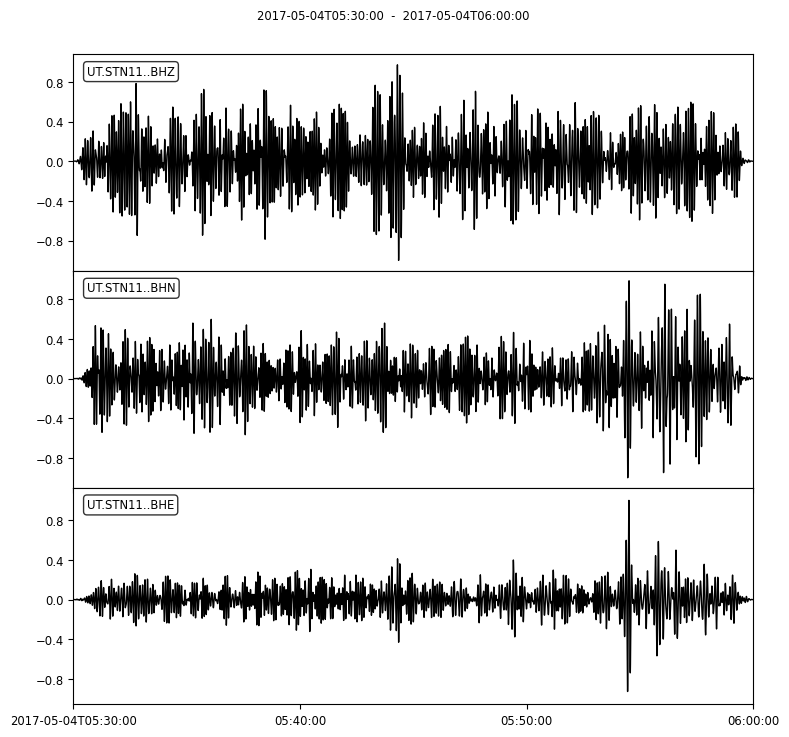

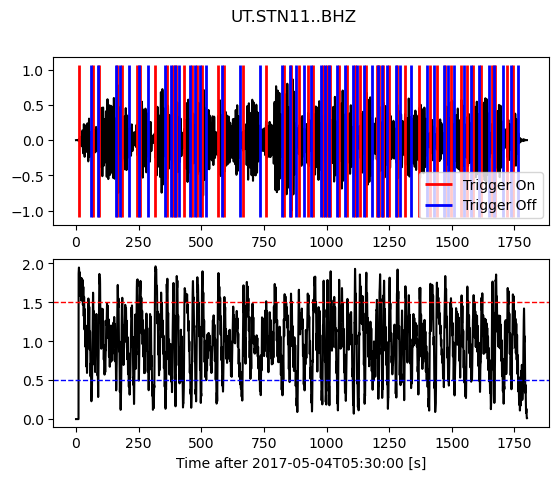

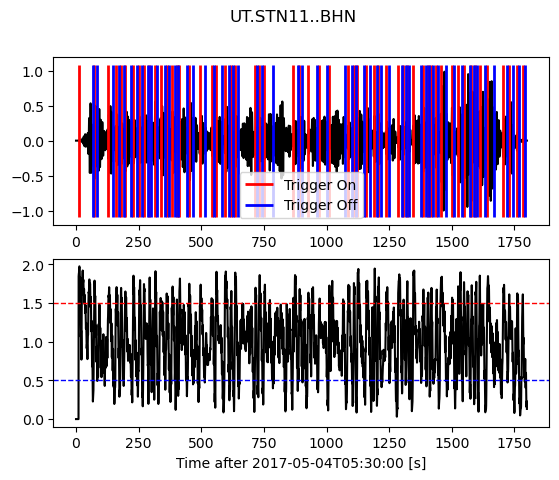

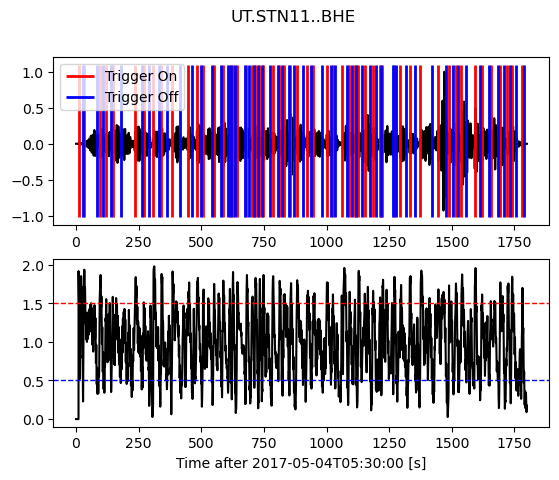

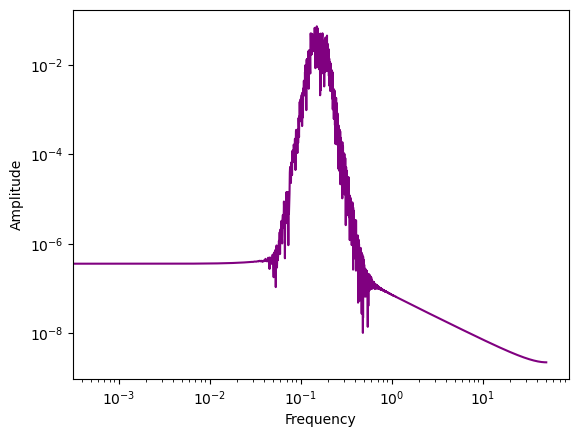

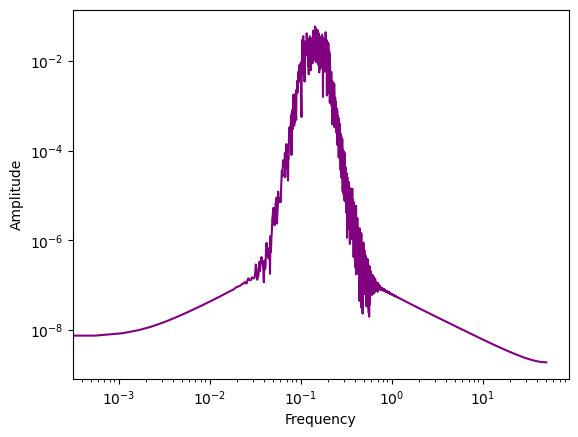

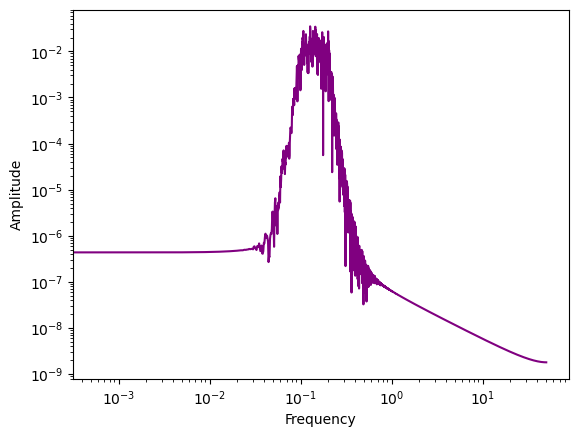

AttributeError: 'hvsr' object has no attribute 'fast_semongko'

In [16]:
e.detrendz()
e.tpr()
e.filterz()
#print(e)
e.normalisasi_td()
e.plot_ts()
e.trigger_sta_lta()
e.transform_tfd()
#e.fast_semongko()

In [ ]:
e.d(amplitude = 12, frequency=3)
e.time()
e.window()
e.fft()

TypeError: hvsr.cekhv() takes 1 positional argument but 3 were given

In [ ]:
pip install fast-konno-ohmachi


     -------------------------------------- 267.1/267.1 kB 1.4 MB/s eta 0:00:00
